In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import os
import pandas as pd
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class TextDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, target = self.sequences[idx]
        return torch.tensor(sequence), torch.tensor(target)
# sys.path.append("..")
# from functions import build_vocab, encode_sequences
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
import re
from collections import Counter
from transformers import BertTokenizer
import pandas as pd
import os
import concurrent.futures
from functools import partial

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower().strip()
    text = re.sub(r'(.)\1+', r'\1\1', text)
    text = re.sub(r'[.,:]', '', text)
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'@\w+', '[MASK]', text)
    return text

def tokenize_text(text, tokenizer):
    cleaned_text = clean_text(text)
    tokens = tokenizer.tokenize(cleaned_text)
    return tokens

def build_vocab(texts, tokenizer):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        tokenize_fn = partial(tokenize_text, tokenizer=tokenizer)
        tokenized_texts = list(executor.map(tokenize_fn, texts))
    
    all_tokens = [token for text in tokenized_texts for token in text]
    token_counts = Counter(all_tokens)
    sorted_tokens = sorted(token_counts, key=token_counts.get, reverse=True)
    if sorted_tokens:
        print(f"Most common tokens: {sorted_tokens[:1]}")
    else:
        print("No tokens found")
    
    word_to_idx = tokenizer.vocab
    return word_to_idx, tokenized_texts

def process_sequence(tokens, word_to_idx, max_seq_length, padding_idx, unk_idx):
    if not tokens:
        return [], [], []
        
    encoded_tokens = [word_to_idx.get(word, unk_idx) for word in tokens]
    sequences = []
    lengths = []
    targets = []

    for i in range(max_seq_length, len(encoded_tokens)):
        sequence = encoded_tokens[i - max_seq_length:i]
        target = encoded_tokens[i]
        
        if len(sequence) < max_seq_length:
            sequence += [padding_idx] * (max_seq_length - len(sequence))
        
        sequences.append(sequence)
        lengths.append(min(len(sequence), max_seq_length))
        targets.append(target)
        
    return sequences, lengths, targets

def encode_sequences(tokenized_texts, word_to_idx, max_seq_length=25, padding_token='[PAD]', unk_token='[UNK]'):
    word_to_idx.setdefault(padding_token, len(word_to_idx))
    word_to_idx.setdefault(unk_token, len(word_to_idx))
    
    padding_idx = word_to_idx[padding_token]
    unk_idx = word_to_idx[unk_token]

    process_fn = partial(process_sequence, 
                        word_to_idx=word_to_idx,
                        max_seq_length=max_seq_length,
                        padding_idx=padding_idx,
                        unk_idx=unk_idx)

    sequences, lengths, targets = [], [], []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(process_fn, tokenized_texts))
        
    for seq, length, target in results:
        sequences.extend(seq)
        lengths.extend(length) 
        targets.extend(target)

    if sequences:
        print(f"Number of sequences generated: {len(sequences)}")
        print(f"Sample sequence: {sequences[0]}")
        print(f"Sample target: {targets[0]}")
    else:
        print("No sequences generated")
        
    return sequences, lengths, targets

folder_path = '../../data/x'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
csv_files = sorted(csv_files)[:10]

from datasets import load_dataset
import pandas as pd
import os
from transformers import BertTokenizer

def get_data():
    try:
        dataset = load_dataset("wikipedia", "20220301.en", split="train[:10000]")
        texts = [{'data': article['text']} for article in dataset]
        df = pd.DataFrame(texts)
        os.makedirs('data', exist_ok=True)
        df.to_csv('data/wiki.csv', index=False)
        print(f"Saved {len(texts)} Wikipedia articles to data/wiki.csv")
    except Exception as e:
        print(f"Error getting data: {str(e)}")

def process_article(text, tokenizer, sequence_length):
    tokens = tokenizer.encode(text, add_special_tokens=True, max_length=256, truncation=True)
    sequences = []
    for i in range(0, len(tokens) - sequence_length):
        sequence = tokens[i:i + sequence_length]
        target = tokens[i + sequence_length]
        sequences.append((sequence, target))
        if len(sequences) >= 100:  # Limit sequences per article
            break
    return sequences

def load_data(sequence_length=25):
    try:
        df = pd.read_csv('data/wiki.csv')
        texts = [row['data'] for _, row in df.iterrows()]
        print(f"Loaded {len(texts)} Wikipedia articles from data/wiki.csv")
        
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        process_fn = partial(process_article, tokenizer=tokenizer, sequence_length=sequence_length)
        
        all_sequences = []
        with concurrent.futures.ThreadPoolExecutor() as executor:
            for sequences in executor.map(process_fn, texts):
                all_sequences.extend(sequences)
                if len(all_sequences) >= 1000:
                    break
                
        print(f"Created {len(all_sequences)} sequences of length {sequence_length}")
        return all_sequences
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return []

get_data()

wikiseq = load_data()

def load_csv_file(file_path):
    try:
        return pd.read_csv(file_path)
    except Exception as e:
        print(f"Error loading file {file_path}: {str(e)}")
        return None

dfs = []
with concurrent.futures.ThreadPoolExecutor() as executor:
    file_paths = [os.path.join(folder_path, file) for file in csv_files]
    results = executor.map(load_csv_file, file_paths)
    dfs.extend([df for df in results if df is not None])

if wikiseq:
    wiki_df = pd.DataFrame({'text': [str(seq[0]) for seq in wikiseq]})
    dfs.append(wiki_df)

if dfs:
    df = pd.concat(dfs, ignore_index=True)
    texts = df['text'].tolist()

    word_to_idx, tokenized_texts = build_vocab(texts, tokenizer)
    sequences, lengths, targets = encode_sequences(tokenized_texts, word_to_idx)

    print(f"Vocabulary size: {len(word_to_idx)}")
    print(f"Number of sequences: {len(sequences)}")
else:
    print("No data loaded")


/home/m/dev/scaleout/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Saved 10000 Wikipedia articles to data/wiki.csv
Loaded 10000 Wikipedia articles from data/wiki.csv
Created 1000 sequences of length 25
Most common tokens: ['i']
Number of sequences generated: 148789
Sample sequence: [103, 2053, 2009, 1005, 1055, 2025, 2022, 3270, 6455, 2012, 2035, 1045, 1005, 1049, 5506, 2339, 2572, 1045, 2182, 1029, 2138, 1045, 2064, 1005, 1056]
Sample target: 2156
Vocabulary size: 30522
Number of sequences: 148789


In [3]:
from torch.utils.data import DataLoader, Dataset
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class TextDataset(Dataset):
    def __init__(self, sequences, lengths, targets):
        self.sequences = sequences
        self.lengths = lengths
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx]), torch.tensor(self.lengths[idx]), torch.tensor(self.targets[idx])

class NextWordLSTM(nn.Module):
    def __init__(self, vocab_size=30522, embed_size=128, hidden_size=256, num_layers=2, repetition_penalty=1.0):
        super(NextWordLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.repetition_penalty = repetition_penalty
    
    def forward(self, x, lengths):

        x = self.embedding(x)

        packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        packed_out, (ht, ct) = self.lstm(packed_input)

        lstm_out, _ = pad_packed_sequence(packed_out, batch_first=True)

        lstm_out = lstm_out[torch.arange(lstm_out.size(0)), lengths - 1]

        out = self.fc(lstm_out)
        
        if self.repetition_penalty != 1.0:
            for i in range(out.size(0)):
                for token in x[i]:
                    if token != 0:
                        out[i, token] /= self.repetition_penalty
        
        return out

train_sequences, val_sequences, train_lengths, val_lengths, train_targets, val_targets = train_test_split(
    sequences, lengths, targets, test_size=0.2, random_state=42)

train_dataset = TextDataset(train_sequences, train_lengths, train_targets)
val_dataset = TextDataset(val_sequences, val_lengths, val_targets)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [4]:
import torch
import torch.optim as optim
import torch.nn as nn

def validate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    with torch.no_grad():  # Disable gradient computation for validation
        for sequences, lengths, targets in val_loader:
            sequences = sequences.to(device)
            lengths = lengths.cpu()
            targets = targets.to(device)
            
            outputs = model(sequences, lengths)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == targets).sum().item()

    avg_loss = total_loss / len(val_loader)
    avg_acc = total_correct / len(val_loader.dataset)
    return avg_loss, avg_acc


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3):
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None
    model.dropout = nn.Dropout(p=0.3)
    
    for epoch in range(num_epochs):
        total_loss = 0
        model.train()

        for batch_idx, (sequences, lengths, targets) in enumerate(train_loader):
            sequences = sequences.to(device)
            lengths = lengths.cpu()
            targets = targets.to(device)

            outputs = model(sequences, lengths)
            loss = criterion(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

            if (batch_idx + 1) % 100 == 0:
                current_loss = total_loss / (batch_idx + 1)
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Current Loss: {current_loss:.4f}')

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        val_loss, val_acc = validate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] completed:')
        print(f'  - Average Train Loss: {avg_train_loss:.4f}')
        print(f'  - Validation Loss: {val_loss:.4f}')
        print(f'  - Validation Accuracy: {val_acc:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  
            best_model = model
            print(f'  - New best validation loss achieved!')
        else:
            patience_counter += 1
            print(f'  - No improvement for {patience_counter} epochs')
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    model = best_model
    return train_losses, val_losses, val_accuracies


model = NextWordLSTM(vocab_size=len(tokenizer.vocab), embed_size=128, hidden_size=256, num_layers=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

print("Starting training...")
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Starting training...
Epoch [1/10], Batch [100/3720], Current Loss: 8.2300
Epoch [1/10], Batch [200/3720], Current Loss: 7.8150
Epoch [1/10], Batch [300/3720], Current Loss: 7.5914
Epoch [1/10], Batch [400/3720], Current Loss: 7.4590
Epoch [1/10], Batch [500/3720], Current Loss: 7.3269
Epoch [1/10], Batch [600/3720], Current Loss: 7.2206
Epoch [1/10], Batch [700/3720], Current Loss: 7.1283
Epoch [1/10], Batch [800/3720], Current Loss: 7.0431
Epoch [1/10], Batch [900/3720], Current Loss: 6.9635
Epoch [1/10], Batch [1000/3720], Current Loss: 6.9047
Epoch [1/10], Batch [1100/3720], Current Loss: 6.8389
Epoch [1/10], Batch [1200/3720], Current Loss: 6.7737
Epoch [1/10], Batch [1300/3720], Current Loss: 6.7274
Epoch [1/10], Batch [1400/3720], Current Loss: 6.6773
Epoch [1/10], Batch [1500/3720], Current Loss: 6.6329
Epoch [1/10], Batch [1600/3720], Current Loss: 6.5891
Epoch [1/10], Batch [1700/3720], Current Loss: 6.5518
Epoch [1/10], Batch [1800/3720], Current Loss: 6.5171
Epoch [1/10], Ba

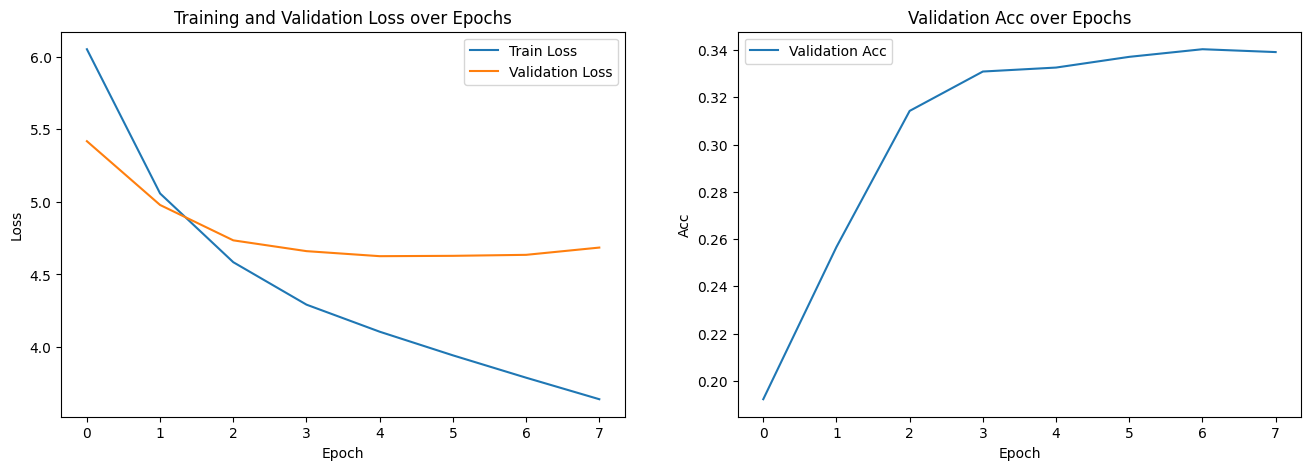

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].plot(train_losses, label="Train Loss")
axs[0].plot(val_losses, label="Validation Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training and Validation Loss over Epochs")
axs[0].legend()

axs[1].plot(val_accuracies, label="Validation Acc")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Acc")
axs[1].set_title("Validation Acc over Epochs")
axs[1].legend()

plt.show()

In [6]:
import json

vocab_save_path = 'vocabulary.json'
with open(vocab_save_path, 'w') as f:
    json.dump(word_to_idx, f)
print(f"Vocabulary saved to {vocab_save_path}")

model_save_path = 'model_low_vocab.pth'
torch.save(model, model_save_path)
torch.save(model.state_dict(), "modelstate.pth")
print(f"Model saved to {model_save_path}")

Vocabulary saved to vocabulary.json
Model saved to model_low_vocab.pth


In [7]:
def predict_next_word(model, sequence, idx_to_word, word_to_idx, seq_length=6):
    model.eval()
    
    padded_sequence = sequence[-seq_length:]
    padded_sequence += [word_to_idx['[PAD]']] * (seq_length - len(padded_sequence))
    
    sequence_tensor = torch.tensor(padded_sequence).unsqueeze(0).to(device)
    lengths = torch.tensor([min(len(sequence), seq_length)], dtype=torch.int64).cpu()
    
    with torch.no_grad():
        output = model(sequence_tensor, lengths)
        
        predicted_idx = torch.argmax(output, dim=1).item()

    return idx_to_word.get(predicted_idx, '[UNK]')

idx_to_word = {idx: word for word, idx in word_to_idx.items()}

short_sequences = [
    "hello",
    "hi",
    "the",
    "a",
    "in",
    "at",
    "on",
    "is",
    "am",
    "i"
]

long_sequences = [
    "what year is it right now and",
    "how are you doing today my friend",
    "the quick brown fox jumps over the",
    "once upon a time in a faraway",
    "to be or not to be that",
    "i have a dream that one day",
    "the sun is shining brightly in the",
    "all you need is love and more",
    "life is like a box of chocolates",
    "in the beginning there was nothing but"
]

print("\nPredictions for short sequences:")
for sequence in short_sequences:
    indata = [word_to_idx.get(word, word_to_idx['[UNK]']) for word in sequence.split()]
    predicted_word = predict_next_word(model, indata, idx_to_word, word_to_idx)
    print(f"'{sequence}' -> '{predicted_word}'")

print("\nPredictions for long sequences:")
for sequence in long_sequences:
    indata = [word_to_idx.get(word, word_to_idx['[UNK]']) for word in sequence.split()]
    predicted_word = predict_next_word(model, indata, idx_to_word, word_to_idx)
    print(f"'{sequence}' -> '{predicted_word}'")



Predictions for short sequences:
'hello' -> ']'
'hi' -> '##4'
'the' -> 'right'
'a' -> 'day'
'in' -> 'the'
'at' -> 'the'
'on' -> 'the'
'is' -> 'a'
'am' -> '299'
'i' -> 'saw'

Predictions for long sequences:
'what year is it right now and' -> 'i'
'how are you doing today my friend' -> 'is'
'the quick brown fox jumps over the' -> 'day'
'once upon a time in a faraway' -> '!'
'to be or not to be that' -> '!'
'i have a dream that one day' -> '!'
'the sun is shining brightly in the' -> 'world'
'all you need is love and more' -> '!'
'life is like a box of chocolates' -> '!'
'in the beginning there was nothing but' -> 'i'
